In [1]:
import sys

sys.path.insert(0, r"K:/Thesis/codes/crypto_project")
sys.path.insert(0, r"E:/Thesis/crypto_project")
import os
import sqlite3
import pandas as pd
import numpy as np
from tqdm.notebook import tqdm
from tqdm import tqdm

DATABASE_LOCATION = r"E:/Thesis/database"
from factor_model.model_update.database_generators import (
    FACTOR_MODEL_ESTIMATES,
    FIX_SET_OF_HALF_LIFES,
    SPECIFIC_RISK,
)
from factor_model.model_update.database_generators.generate_databases import (
    refresh_database,
)
import datetime
from factor_model.risk_calculations.core_universe_portfolio import (
    generate_market_portfolio,
)

EXPOSURE_NON_STYLE_FIELDS = [
    "id",
    "ticker",
    "return",
    "core_universe",
    "transformed_market_cap",
    "date",
]
from factor_model.model_update.database_generators import EXPOSURE_NON_STYLE_FIELDS

from factor_model.risk_calculations.risk_attribution import (
    create_portfolio_exposures,
    generate_factor_covariance_attribution,
    calculate_spec_risk_mctr,
    generate_factor_covariance_table,
    generate_active_space_portfolio,
    get_specific_risk_beta,
)
from factor_model.risk_calculations.factor_covariance import (
    generate_factor_covariance_matrix,
)
from factor_model.risk_calculations.specific_risk import (
    generate_raw_specific_risk,
    generate_raw_portfolio_specific_risk,
)
from factor_model.risk_calculations.risk_metrics import calculate_lognormal_es_var

#### USER INPUT example


In [153]:
# A sample portfolio to test calculations and restrict query...
portfolio_details = {
    "BCUBE-USD": 0.17,
    "LNC-USD": 0.05,
    # "PMG24050-USD": 0.2,
    "ZNN-USD": 0.04,
    "EFI-USD": 0.03,
    "BTC-USD": 0.32,
    "ETH-USD": 0.19,
    "USDT-USD": 0.1,
    "BNB-USD": 0.1,
}

market_portfolio = {
    "BTC-USD": 0.31574372070244366,
    "ETH-USD": 0.18711055133973806,
    "USDT-USD": 0.08725061854643708,
    "BNB-USD": 0.06932395681724883,
    "SOL-USD": 0.06602083999170749,
    "STETH-USD": 0.0534749145676961,
    "XRP-USD": 0.05020181639431607,
    "USDC-USD": 0.046874562996328084,
    "ADA-USD": 0.04406750903164565,
    "DOGE-USD": 0.041257706928259585,
    "SHIB-USD": 0.03867380268417949,
}

# risk calculation
risk_calculation_parameters = {
    "correlation_half_life": 730,  # days
    "variance_half_life": 365,  # days
    "specific_risk_half_life": 365,
    "date": "2023-03-01",
    "minimum_history_spec_ret": 730,
    "mean_to_zero": False,
}

portfolio_details= {'BTC-USD': 0.5, 'ETH-USD': 0.5}
market_portfolio={'BTC-USD': 0.5, 'ETH-USD': 0.5}

# risk calculation
risk_calculation_parameters = {
    "correlation_half_life": 300,  # days
    "variance_half_life": 300,  # days
    "specific_risk_half_life": 300,
    "date": "2023-03-01",
    "minimum_history_spec_ret": 300,
    "mean_to_zero": False,
}
# alias
cob_date = risk_calculation_parameters["date"]

#### 0. Load relevant input data

##### Ideally this should be supplied through Django db queries


In [154]:
with sqlite3.connect(os.path.join(DATABASE_LOCATION, FACTOR_MODEL_ESTIMATES)) as conn:
    exposures = pd.read_sql_query(
        f"SELECT * FROM exposures where date = '{cob_date}'",
        conn,
    )

with sqlite3.connect(os.path.join(DATABASE_LOCATION, FACTOR_MODEL_ESTIMATES)) as conn:
    factor_returns = pd.read_sql_query(
        "SELECT * FROM factor_returns where date <= '{cob_date}'", conn
    )

# for spec risk (raw), only load relevant symbols
# prerequisite is the market_portolios constituents + user provided constituents
# date should also be supplied
if market_portfolio is None:
    market_portfolio = generate_market_portfolio(exposures)
all_tickers = list(set(market_portfolio.keys()).union(set(portfolio_details.keys())))
all_tickers_str = "','".join(all_tickers)
with sqlite3.connect(os.path.join(DATABASE_LOCATION, FACTOR_MODEL_ESTIMATES)) as conn:
    full_specific_returns = pd.read_sql_query(
        f"SELECT * FROM specific_returns where date<='{cob_date}' and ticker in ('{all_tickers_str}')",
        conn,
    )

In [155]:
#### TODO how the fuck do I know which factors are available???

#### 1. Calculate exposures


In [156]:
factor_covariance = generate_factor_covariance_matrix(
    factor_returns, risk_calculation_parameters
)

active_space_port = generate_active_space_portfolio(portfolio_details, market_portfolio)

In [157]:
portfolios = {
    "portfolio": portfolio_details,
    "market": market_portfolio,
    "active": active_space_port,
}

port_exposures = {}
factor_risks = {}
factor_attributions = {}
factor_covars = {}
raw_specific_risks = {}
spec_risk_availabilities = {}
spec_risks = {}
total_risks = {}
factor_mctrs = {}
spec_risk_attributions = {}
spec_risk_var_decomps = {}
spec_risk_mctrs = {}
for port in portfolios.keys():
    # 1. exposure calc
    port_exposures[port] = create_portfolio_exposures(
        exposures=exposures,
        portfolio_details=portfolios[port],
        non_style_fields=EXPOSURE_NON_STYLE_FIELDS,
        is_total_space=True if port != "active" else False,
    )
    port_exposures[port] = port_exposures[port].reindex(factor_covariance.index)
    # 2. factor risk related
    (
        factor_risks[port],
        factor_attributions[port],
    ) = generate_factor_covariance_attribution(port_exposures[port], factor_covariance)
    factor_covars[port] = generate_factor_covariance_table(
        port_exposures[port], factor_covariance
    )
    # 3. spec risk related
    (
        raw_specific_risks[port],
        spec_risk_availabilities[port],
    ) = generate_raw_specific_risk(
        full_specific_returns, risk_calculation_parameters, portfolios[port]
    )
    spec_risks[port] = generate_raw_portfolio_specific_risk(
        raw_specific_risks[port],
        portfolios[port],
        is_total_space=True if port != "active" else False,
    )
    total_risks[port] = np.sqrt(factor_risks[port] ** 2 + spec_risks[port] ** 2)

    factor_mctrs[port] = factor_attributions[port] / total_risks[port]
    spec_risk_attributions[port], spec_risk_var_decomps[port] = (
        calculate_spec_risk_mctr(
            raw_specific_risks[port],
            portfolios[port],
            is_total_space=True if port != "active" else False,
        )
    )
    spec_risk_mctrs[port] = spec_risk_attributions[port] / total_risks[port]

# 4. beta calculation...
factor_beta_covar, _ = generate_factor_covariance_attribution(
    port_exposures["portfolio"], factor_covariance, port_exposures["market"]
)
spec_risk_covar = get_specific_risk_beta(
    portfolios["portfolio"],
    market_portfolio=portfolios["market"],
    spec_risk=raw_specific_risks["active"],
)
portfolio_beta = (factor_beta_covar**2 + spec_risk_covar) / (total_risks["market"] ** 2)

# 5. expected shortfall calculation assuming normality, 1 Day
es95, var95 = calculate_lognormal_es_var(total_risks["portfolio"], 0.95)
es99, var99 = calculate_lognormal_es_var(total_risks["portfolio"], 0.99)

In [158]:
(
    raw_specific_risks[port],
    spec_risk_availabilities[port],
) = generate_raw_specific_risk(
    full_specific_returns, risk_calculation_parameters, portfolios[port]
)
from factor_model.risk_calculations.specific_risk import closest_halflife_element

closest_hls = closest_halflife_element(FIX_SET_OF_HALF_LIFES, 5)

In [159]:
relevant_hls = ",".join([str(val) for val in closest_hls])
with sqlite3.connect(os.path.join(DATABASE_LOCATION, SPECIFIC_RISK)) as conn:
    core_spec_risk_df = pd.read_sql_query(
        f"SELECT * FROM core_specific_risk where date = '{cob_date}' and half_life in ({relevant_hls})",
        conn,
    )

In [160]:
if len(core_spec_risk_df) < 2:
    core_half_life = core_spec_risk_df["specific_risk"].values[0]
else:
    core_half_life = np.interp(
        5, core_spec_risk_df["half_life"], core_spec_risk_df["specific_risk"]
    )

In [161]:
from typing import Dict


portfolio = "portfolio"
spec_risk = spec_risks[portfolio]
factor_covar = factor_covars[portfolio]
total_risk = total_risks[portfolio]


def decompose_risk(
    total_risk: float, factor_covar: pd.DataFrame, spec_risk: float = None
) -> Dict[str, float]:
    """Generates portfolio risk decomposition
    If more than 10 factors are provided the top 10 contributors are provided

    Args:
        total_risk (float): total risk values
        factor_covar (pd.DataFrame): factor covariance decomposition (n*n)
        spec_risk (float, optional): specific risk value. Defaults to None.

    Returns:
        Dict[str, float]: _description_
    """
    total_variance = total_risk**2
    all_ratios = {}
    if spec_risk is not None:
        spec_risk_ratio = (spec_risk**2) / total_variance
        all_ratios["specific_risk"] = spec_risk_ratio

    trace_sum = factor_covar.to_numpy().trace()
    diversification_ratio = (factor_covar.sum().sum() - trace_sum) / total_variance
    factor_ratios = (
        pd.Series(factor_covar.to_numpy().diagonal(), index=factor_covar.index)
        / total_variance
    )
    n_largest_elems = list(abs(factor_ratios.copy()).nlargest(10).index)
    if len(factor_ratios) > len(n_largest_elems):
        other_elems_ratio = factor_ratios[
            ~factor_ratios.index.isin(n_largest_elems)
        ].sum()
        factor_ratios = (
            factor_ratios[factor_ratios.index.isin(n_largest_elems)].copy().to_dict()
        )
        all_ratios = {**all_ratios, "other": other_elems_ratio}
    else:
        factor_ratios = factor_ratios.to_dict()

    all_ratios = {
        **all_ratios,
        **factor_ratios,
        **{"diversification": diversification_ratio},
    }
    return (pd.Series(all_ratios) * total_risk).sort_values(ascending=False).to_dict()


risk_decomposition = {}
for portfolio in portfolios.keys():
    risk_decomposition[portfolio] = decompose_risk(
        total_risk=total_risks[portfolio],
        factor_covar=factor_covars[portfolio],
        spec_risk=spec_risks[portfolio],
    )
    print(sum(risk_decomposition[portfolio].values())/total_risks[portfolio])

0.9999999999999998
0.9999999999999998
nan


C:\Users\Bebesi Laci\AppData\Local\Temp\ipykernel_12472\960299520.py:27: RuntimeWarning: invalid value encountered in double_scalars
  spec_risk_ratio = (spec_risk**2) / total_variance
C:\Users\Bebesi Laci\AppData\Local\Temp\ipykernel_12472\960299520.py:31: RuntimeWarning: invalid value encountered in double_scalars
  diversification_ratio = (factor_covar.sum().sum() - trace_sum) / total_variance


In [166]:
risk_decomposition

{'portfolio': {'market': 0.040280629412916706,
  'size': 0.0064266787982718366,
  'volume': 0.005397635769782655,
  'specific_risk': 0.002106068931422805,
  'new_coin': 0.0005063179280436031,
  'reversal': 0.00015614665830241848,
  'momentum': 2.9603064679489345e-05,
  'diversification': -0.019292727369762536},
 'market': {'market': 0.040280629412916706,
  'size': 0.0064266787982718366,
  'volume': 0.005397635769782655,
  'specific_risk': 0.002106068931422805,
  'new_coin': 0.0005063179280436031,
  'reversal': 0.00015614665830241848,
  'momentum': 2.9603064679489345e-05,
  'diversification': -0.019292727369762536},
 'active': {'other': 0.0, 'specific_risk': nan, 'diversification': nan}}

In [180]:
risk_decomposition_mod = {}
for port in risk_decomposition.keys():
    for key in risk_decomposition[port].keys():
        if key not in risk_decomposition_mod.keys():
            risk_decomposition_mod[key] = {}
        if port == "market":
            port_ = "benchmark"
        else:
            port_ = port
        risk_decomposition_mod[key][port_] = risk_decomposition[port].get(key, 0.0) * 100
        risk_decomposition_mod[key][port_] = 0.0 if pd.isna(risk_decomposition_mod[key][port_]) else risk_decomposition_mod[key][port_]
for key in risk_decomposition_mod.keys():
    for col in ["portfolio", "benchmark", "active"]:
        if col not in risk_decomposition_mod[key]:
            risk_decomposition_mod[key][col] = 0.0
    risk_decomposition_mod[key] = dict(sorted(risk_decomposition_mod[key].items()), reverse=True)

In [186]:
dict(sorted(risk_decomposition_mod[key].items()), reverse=True)

{'active': 0.0, 'benchmark': 0.0, 'portfolio': 0.0, 'reverse': True}

In [140]:
sum({'Factor2': 1.3927150363238816,
                    'Factor1': 1.0213243599708464,
                    'diversification': -0.9284766908825876
                    }.values())

1.4855627054121405

#### Plot stuff here


In [11]:
import seaborn as sns
import matplotlib.pyplot as plt

pd.set_option("display.precision", 4)
pd.options.display.float_format = "{:,.4f}".format

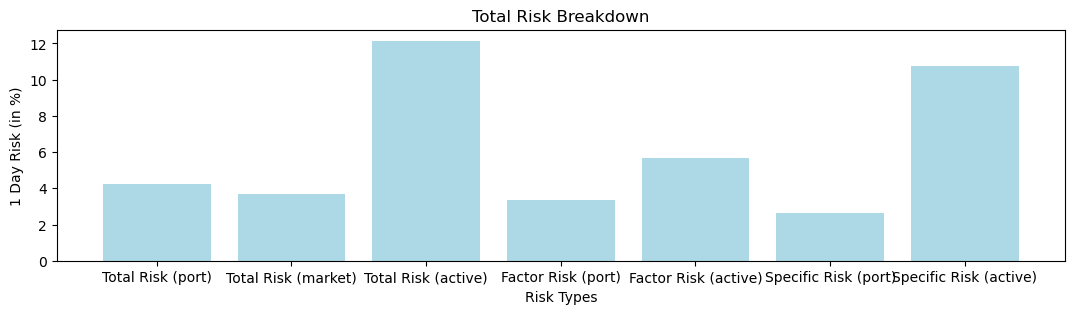

In [12]:
categories = [
    "Total Risk (port)",
    "Total Risk (market)",
    "Total Risk (active)",
    "Factor Risk (port)",
    "Factor Risk (active)",
    "Specific Risk (port)",
    "Specific Risk (active)",
]

values = [
    total_risks["portfolio"] * 100,
    total_risks["market"] * 100,
    total_risks["active"] * 100,
    factor_risks["portfolio"] * 100,
    factor_risks["active"] * 100,
    spec_risks["portfolio"] * 100,
    spec_risks["active"] * 100,
]

plt.figure(figsize=(13, 3))

plt.bar(categories, values, color="lightblue")

plt.xlabel("Risk Types")

plt.ylabel("1 Day Risk (in %)")

plt.title("Total Risk Breakdown")

plt.show()

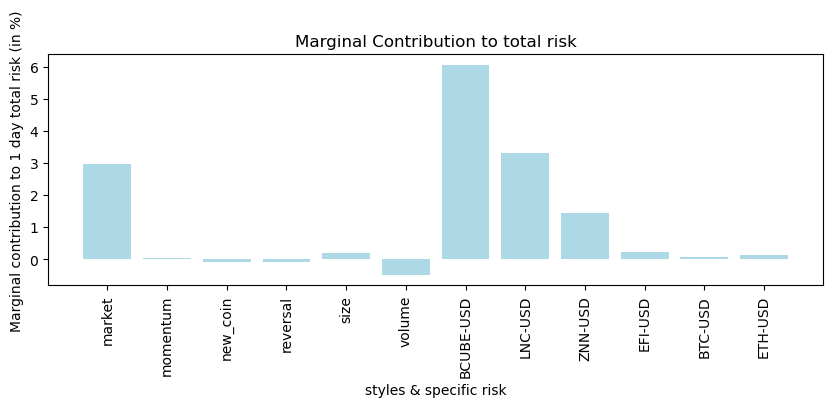

In [13]:
all_mctr = factor_mctrs["portfolio"].append(spec_risk_mctrs["portfolio"])
plt.figure(figsize=(10, 3))
plt.bar(all_mctr.index, all_mctr * 100, color="lightblue")
plt.ylabel("Marginal contribution to 1 day total risk (in %)")
plt.title("Marginal Contribution to total risk")
plt.xlabel("styles & specific risk")
plt.xticks(all_mctr.index, rotation=90)

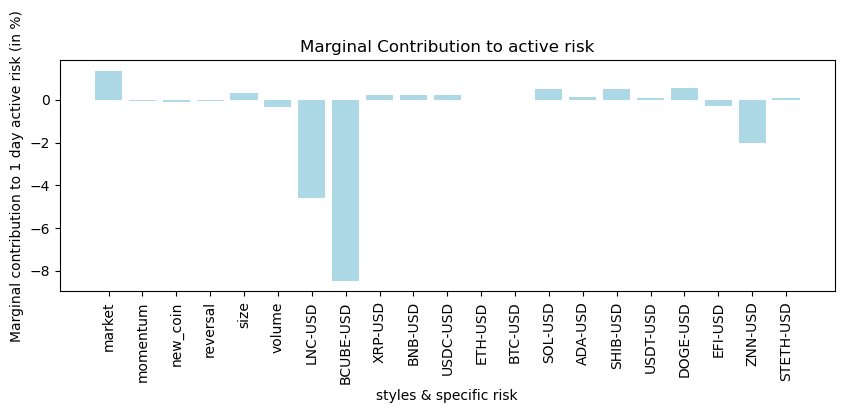

In [14]:
all_mctr = factor_mctrs["active"].append(spec_risk_mctrs["active"])
plt.figure(figsize=(10, 3))
plt.bar(all_mctr.index, all_mctr * 100, color="lightblue")
plt.ylabel("Marginal contribution to 1 day active risk (in %)")
plt.title("Marginal Contribution to active risk")
plt.xlabel("styles & specific risk")
plt.xticks(all_mctr.index, rotation=90)

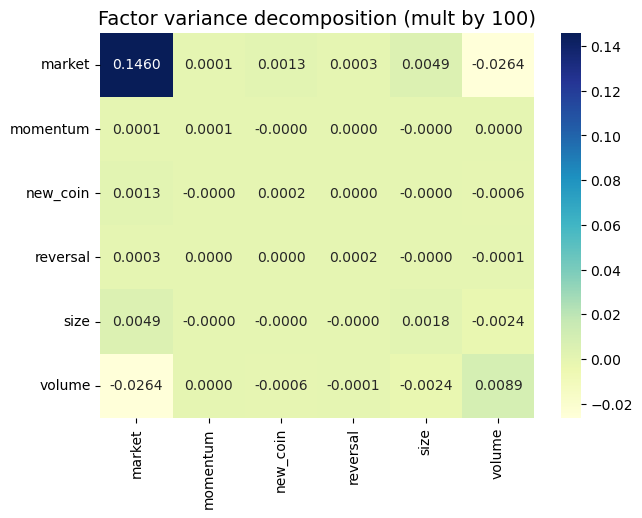

In [15]:
plt.figure(figsize=(7, 5))
ax = sns.heatmap(factor_covars["portfolio"] * 100, cmap="YlGnBu", annot=True, fmt=".4f")
plt.title("Factor variance decomposition (mult by 100)", fontsize=14)

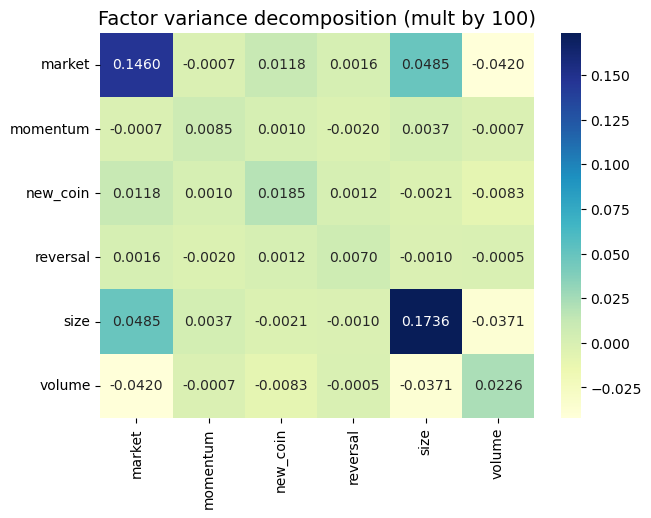

In [16]:
plt.figure(figsize=(7, 5))
ax = sns.heatmap(factor_covars["active"] * 100, cmap="YlGnBu", annot=True, fmt=".4f")
plt.title("Factor variance decomposition (mult by 100)", fontsize=14)